In [ ]:
import abc
import os
from zipfile import ZipFile
from pathlib import Path
import numpy as np
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-1m.zip

movielens_data_file_url = \
  "https://files.grouplens.org/datasets/movielens/ml-1m.zip"


movielens_zipped_file = tf.keras.utils.get_file("ml-1m.zip",
                                                movielens_data_file_url,
                                                extract=False)

keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-1m"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

5917549/5917549 [==============================] - 0s 0us/step
Extracting all the files now...
Done!


In [ ]:
columns = ['user_id', 'item_id', 'rating', 'timestamp']
movielens_file = os.path.join(movielens_dir, "ratings.dat")
df = pd.read_csv(movielens_file, sep='::', names=columns)
print('There are %s users, %s itmes and %s pairs in the dataset' \
      %(df.user_id.unique().shape[0], df.item_id.unique().shape[0], df.shape[0]))
df.head()

<ipython-input-4-a691c8fd4680>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(movielens_file, sep='::', names=columns)


There are 6040 users, 3706 itmes and 1000209 pairs in the dataset


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
items_id_file = os.path.join(movielens_dir, "movies.dat")

In [ ]:
columns = ['item_id', 'movie_title', 'Genres']
df_item_info = pd.read_csv(items_id_file, sep='::', names=columns, encoding = "latin")
df_item_info = df_item_info[['item_id', 'movie_title']].drop_duplicates()
df_item_info.head()

<ipython-input-6-3246c5f0f0b0>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_item_info = pd.read_csv(items_id_file, sep='::', names=columns, encoding = "latin")


,item_id,movie_title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [ ]:
len(df_item_info), len(df_item_info.item_id.unique()), len(df_item_info.movie_title.unique())

(3883, 3883, 3883)

In [ ]:
mostRated = df.groupby('item_id')['user_id'].count().reset_index()
mostRated.head()

,item_id,user_id
0,1,2077
1,2,701
2,3,478
3,4,170
4,5,296


In [ ]:
mostRated = pd.merge(mostRated, df_item_info, on=['item_id'], how='inner').sort_values(by='user_id', ascending=False)
mostRated.head(10)

,item_id,user_id,movie_title
2651,2858,3428,American Beauty (1999)
253,260,2991,Star Wars: Episode IV - A New Hope (1977)
1106,1196,2990,Star Wars: Episode V - The Empire Strikes Back...
1120,1210,2883,Star Wars: Episode VI - Return of the Jedi (1983)
466,480,2672,Jurassic Park (1993)
1848,2028,2653,Saving Private Ryan (1998)
575,589,2649,Terminator 2: Judgment Day (1991)
2374,2571,2590,"Matrix, The (1999)"
1178,1270,2583,Back to the Future (1985)
579,593,2578,"Silence of the Lambs, The (1991)"


In [ ]:
# train data
train, test = train_test_split(df, test_size=0.2)

# users, items and pairs
df_users = train.drop_duplicates(subset=['user_id'])[['user_id']]
df_users['user'] = np.arange(len(df_users))
df_items = train.drop_duplicates(subset=['item_id'])[['item_id']]
df_items['item'] = np.arange(len(df_items))
num_users = len(df_users)
num_items = len(df_items)
num_pairs = train.shape[0]
print('There are %s users, %s items and %s pairs in the train set' \
      %(num_users, num_items, num_pairs))

# new ids
train = pd.merge(train, df_users, on=['user_id'])
train = pd.merge(train, df_items, on=['item_id'])

# get x, y values
x_train, y_train = train[['user', 'item']], train[['rating']].astype(float)

There are 6040 users, 3680 items and 800167 pairs in the train set


In [ ]:
# test data
test = pd.merge(test, df_users, on=['user_id'], how='inner')
test = pd.merge(test, df_items, on=['item_id'], how='inner')
print('There are %s users, %s items and %s pairs in the train set' \
      %(len(test['user_id'].unique()), len(test['item_id'].unique()), test.shape[0]))

# get x, y values
x_test, y_test = test[['user', 'item']], test[['rating']].astype(float)

There are 6038 users, 3434 items and 200011 pairs in the train set


In [ ]:
class MatrixFactorization(tf.keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super(MatrixFactorization, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.user_embedding = tf.keras.layers.Embedding(
            self.num_users,
            embedding_size,
            #embeddings_initializer="he_normal",
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
        )
        self.user_bias = tf.keras.layers.Embedding(self.num_users, 1)
        self.item_embedding = tf.keras.layers.Embedding(
            self.num_items,
            embedding_size,
            #embeddings_initializer="he_normal",
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
        )
        self.item_bias = tf.keras.layers.Embedding(self.num_items, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        output = dot_user_item + user_bias + item_bias
        return output

In [ ]:
EMBEDDING_SIZE = 10

In [ ]:
model = MatrixFactorization(num_users, num_items, EMBEDDING_SIZE)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(lr=1e-4))

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=30,
    verbose=1,
    validation_data=(x_test, y_test)
)

Epoch 1/30
12503/12503 [==============================] - 42s 3ms/step - loss: 1.9782 - val_loss: 1.9046
Epoch 2/30
12503/12503 [==============================] - 42s 3ms/step - loss: 0.9157 - val_loss: 1.7718
Epoch 3/30
12503/12503 [==============================] - 41s 3ms/step - loss: 0.9039 - val_loss: 1.7359
Epoch 4/30
12503/12503 [==============================] - 40s 3ms/step - loss: 0.9062 - val_loss: 1.6552
Epoch 5/30
12503/12503 [==============================] - 44s 4ms/step - loss: 0.9064 - val_loss: 1.6518
Epoch 6/30
12503/12503 [==============================] - 40s 3ms/step - loss: 0.9081 - val_loss: 1.6008
Epoch 7/30
12503/12503 [==============================] - 39s 3ms/step - loss: 0.9041 - val_loss: 1.4643
Epoch 8/30
12503/12503 [==============================] - 38s 3ms/step - loss: 0.9048 - val_loss: 1.4547
Epoch 9/30
12503/12503 [==============================] - 38s 3ms/step - loss: 0.9042 - val_loss: 1.4422
Epoch 10/30
12503/12503 [==============================

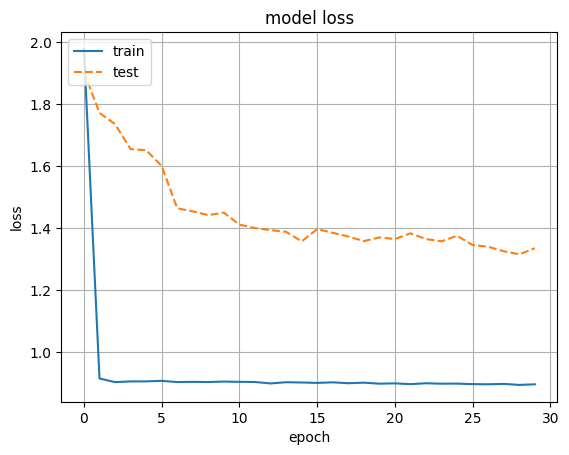

In [16]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"], '--')
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

In [17]:
def recommend(user_id, train, test, df_items, df_aux):
  movies_watched_by_user = train[train.user == user_id]

  df_items_aux = df_items[['item']]
  df_items_aux['user'] = user_id
  movies_not_watched = pd.merge(df_items_aux, movies_watched_by_user, on=['user', 'item'], how='left')
  movies_not_watched = movies_not_watched[movies_not_watched.rating.isnull()][['user', 'item']]

  ratings = model.predict(movies_not_watched).flatten()
  movies_not_watched['predicted_rating'] = ratings
  top_ratings_items = movies_not_watched.sort_values(by='predicted_rating', ascending=False)

  print("Showing recommendations for user: {}".format(user_id))
  print("====" * 9)
  print("Movies with high ratings from user")
  print("----" * 8)

  movies_watched_by_user = pd.merge(movies_watched_by_user, df_aux, on=['item_id'])
  top_movies_user = movies_watched_by_user.sort_values(by='rating', ascending=False)[['user', 'item', 'rating', 'movie_title']]
  print(top_movies_user.head(20))

  print("====" * 9)
  print("Ratings of movies watched in test")
  print("----" * 8)
  movies_watched_by_user_test = test[test.user == user_id]
  movies_watched_by_user_test = pd.merge(movies_watched_by_user_test, df_aux, on=['item_id'])
  movies_watched_by_user_test = pd.merge(movies_watched_by_user_test, movies_not_watched, on=['user', 'item'])
  movies_user_test = movies_watched_by_user_test.sort_values(by='rating', ascending=False)[['user', 'item', 'rating', 'predicted_rating', 'movie_title']]
  print(movies_user_test.head(20))

  print("----" * 8)
  print("Top 10 movie recommendations")
  print("----" * 8)
  top_movies_recommended = pd.merge(top_ratings_items, df_items, on=['item'])
  top_movies_recommended = pd.merge(top_movies_recommended, df_aux, on=['item_id'])
  print(top_movies_recommended[['item', 'predicted_rating', 'movie_title']].head(20))


In [18]:
user_id = test.user.sample(10).iloc[0]
recommend(user_id, train, test, df_items, df_item_info)

115/115 [==============================] - 1s 3ms/step
Showing recommendations for user: 5526
Movies with high ratings from user
--------------------------------
    user  item  rating                                        movie_title
2   5526    94       5                   Shawshank Redemption, The (1994)
8   5526   158       5                              Godfather, The (1972)
13  5526  1178       4                     When Harry Met Sally... (1989)
11  5526   990       4                        White Men Can't Jump (1992)
17  5526   412       4        South Park: Bigger, Longer and Uncut (1999)
16  5526  1155       4                               Billy Madison (1995)
15  5526  1756       4                                   Liar Liar (1997)
14  5526   425       4                          Christmas Story, A (1983)
20  5526   128       4                          Back to the Future (1985)
21  5526   657       4                             Doctor Dolittle (1998)
22  5526   433       4  